In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt

# New Bridges in Bangladesh
(inspired by [this article](https://www.economist.com/asia/2022/07/07/new-transport-infrastructure-helps-south-asian-women-into-work) in The Economist about how bridges help women find work.)

In [2]:
# download the graph
%time G = ox.graph_from_place('Bangladesh', network_type='drive')

CPU times: user 11min 19s, sys: 25.6 s, total: 11min 45s
Wall time: 18min 39s


In [3]:
# get the node, edge geometries
N, E = ox.graph_to_gdfs(G)

# project the network to web mercator
N = N.to_crs(3857)
E = E.to_crs(3857)

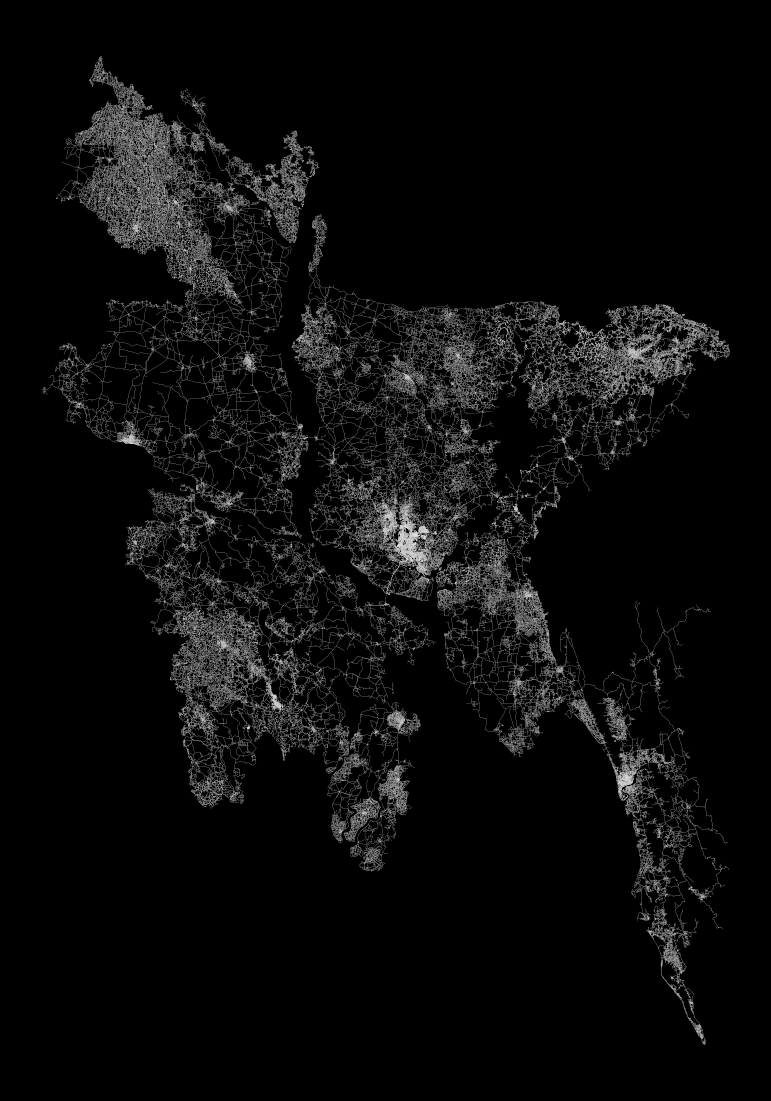

In [4]:
fig, ax = plt.subplots(1, 1, figsize = (20, 20), facecolor = 'k')

E.plot(color='w', ax=ax, linewidth=0.1)
ax.set_axis_off()
ax.set_facecolor('k')

These next blocks allow you to explore the map and identify certain parts of the street network, in this case the bridges. 

In [5]:
# E[ox.io._stringify_nonnumeric_cols(E).name.str.contains("বঙ্গবন্ধু সেতু")].explore()

In [6]:
# E[ox.io._stringify_nonnumeric_cols(E).name.str.contains("পদ্মা সেতু")].explore()

In [7]:
# let's identify dhaka on the map
dhaka = ox.geocoder.geocode("Dhaka, Bangladesh")
# the let's find a node in the street network to represent it
dhaka = ox.distance.nearest_nodes(G, dhaka[1], dhaka[0], return_dist=False)

In [8]:
from colorcet import palette
from matplotlib import colors

# colorcet is a cool library for perceptually uniform colormaps, note that [::-1] reverses the colormap
col = colors.LinearSegmentedColormap.from_list("bmw", palette['bmw'][::-1])

In [55]:
# we need to simulate removing/adding these bridges (identifed on openstreetmap.org with the query tooltip)
jamuna = E[ox.io._stringify_nonnumeric_cols(E).name.str.contains("বঙ্গবন্ধু সেতু")].reset_index()
# in the process of topologically simplifying OSMnx combines roads and creates list columns that need to be converted into strings
padma = E[ox.io._stringify_nonnumeric_cols(E).osmid.str.contains("1067519232") | ox.io._stringify_nonnumeric_cols(E).osmid.str.contains("1067519237")].reset_index()

In [56]:
# we will set up a few boxes to highlight the areas of interest
aoi_j = gpd.GeoDataFrame(geometry=gpd.GeoSeries(jamuna.geometry.unary_union.buffer(10000).envelope), crs=3857)
aoi_p = gpd.GeoDataFrame(geometry=gpd.GeoSeries(padma.geometry.unary_union.buffer(10000).envelope), crs=3857)

In [57]:
# set up a function to remove bridges
def cut_bridge(graph, bridge):
    
    graph = graph.copy()
    for i, r in bridge.iterrows():
        graph.remove_edge(r['u'], r['v'])
        
    return graph

In [58]:
# no jamuna
G_pre = cut_bridge(G, jamuna)

# no padma
G_pre = cut_bridge(G_pre, padma)

In [59]:
# here is the network with no bridges
N_pre, E_pre = ox.graph_to_gdfs(G_pre)

E_pre = E_pre.to_crs(3857)
N_pre = N_pre.to_crs(3857)

In [60]:
# get the shortest path from dhaka (single source) to all other nodes
%time pre_isolines = nx.single_source_dijkstra(G_pre, dhaka, weight='length')

CPU times: user 1.83 s, sys: 167 ms, total: 2 s
Wall time: 2 s


In [61]:
# unpack the distances into a dataframe
pre_distances = pd.DataFrame({'osmid': pre_isolines[0].keys(), 'distance': pre_isolines[0].values()})

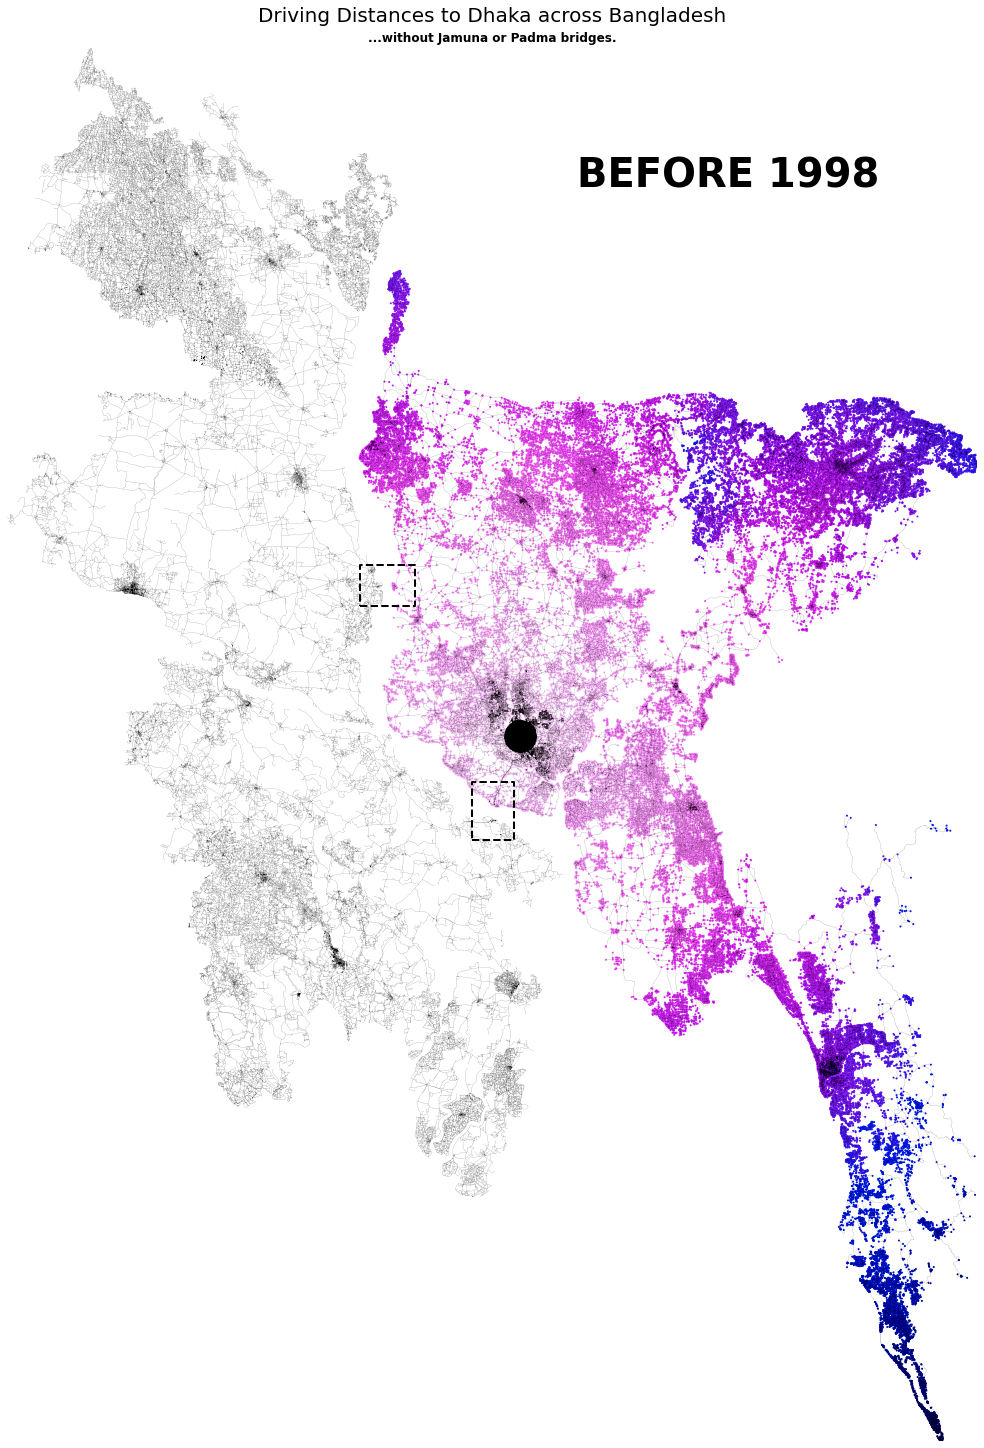

In [63]:
# plot the results
fig, ax = plt.subplots(1, 1, figsize=(20, 20), 
                       facecolor='w',
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

# plot the network
E_pre.plot(color='k', linewidth=0.05, ax=ax)

# plot the isolines
N_pre.merge(pre_distances, 
            left_on='osmid', 
            right_on='osmid', 
            how='left').to_crs(3857).plot('distance', markersize=1, cmap=col, ax=ax,
                                         vmin=pre_distances.distance.min(),
                                         vmax=pre_distances.distance.max())

# plot the aois
aoi_j.boundary.plot(color='k', linestyle='dashed', linewidth=2, ax=ax)
aoi_p.boundary.plot(color='k', linestyle='dashed', linewidth=2, ax=ax)

# put a marker for dhaka
N[N.index==dhaka].plot(color='k', markersize=1000, ax=ax)

# annotation
ax.text(0.9, 0.9,
        "BEFORE 1998",
        color="k",
        weight='bold',
        fontsize=40,
        ha="right",
        transform=ax.transAxes,
       )


# set the extent
ax.set_xlim((N.geometry.x.min(), N.geometry.x.max()))
ax.set_ylim((N.geometry.y.min(), N.geometry.y.max()))

# set the title
ax.set_title("...without Jamuna or Padma bridges.", color='k', weight='bold')

# clean up the axes
ax.set_axis_off()

# save the figure
fig.suptitle("Driving Distances to Dhaka across Bangladesh", fontsize=20, color='k')
fig.savefig('./images/scenarios/bangladesh-1.png', facecolor=fig.get_facecolor(), dpi=300, bbox_inches='tight')

Now we are just going to repeat that process for later versions of the network.

In [64]:
# no padma
G_mid = cut_bridge(G, padma)

In [65]:
N_mid, E_mid = ox.graph_to_gdfs(G_mid)

E_mid = E_mid.to_crs(3857)
N_mid = N_mid.to_crs(3857)

In [66]:
%time mid_isolines = nx.single_source_dijkstra(G_mid, dhaka, weight='length')

CPU times: user 4.19 s, sys: 441 ms, total: 4.64 s
Wall time: 4.64 s


In [67]:
 mid_distances = pd.DataFrame({'osmid': mid_isolines[0].keys(), 'distance': mid_isolines[0].values()})

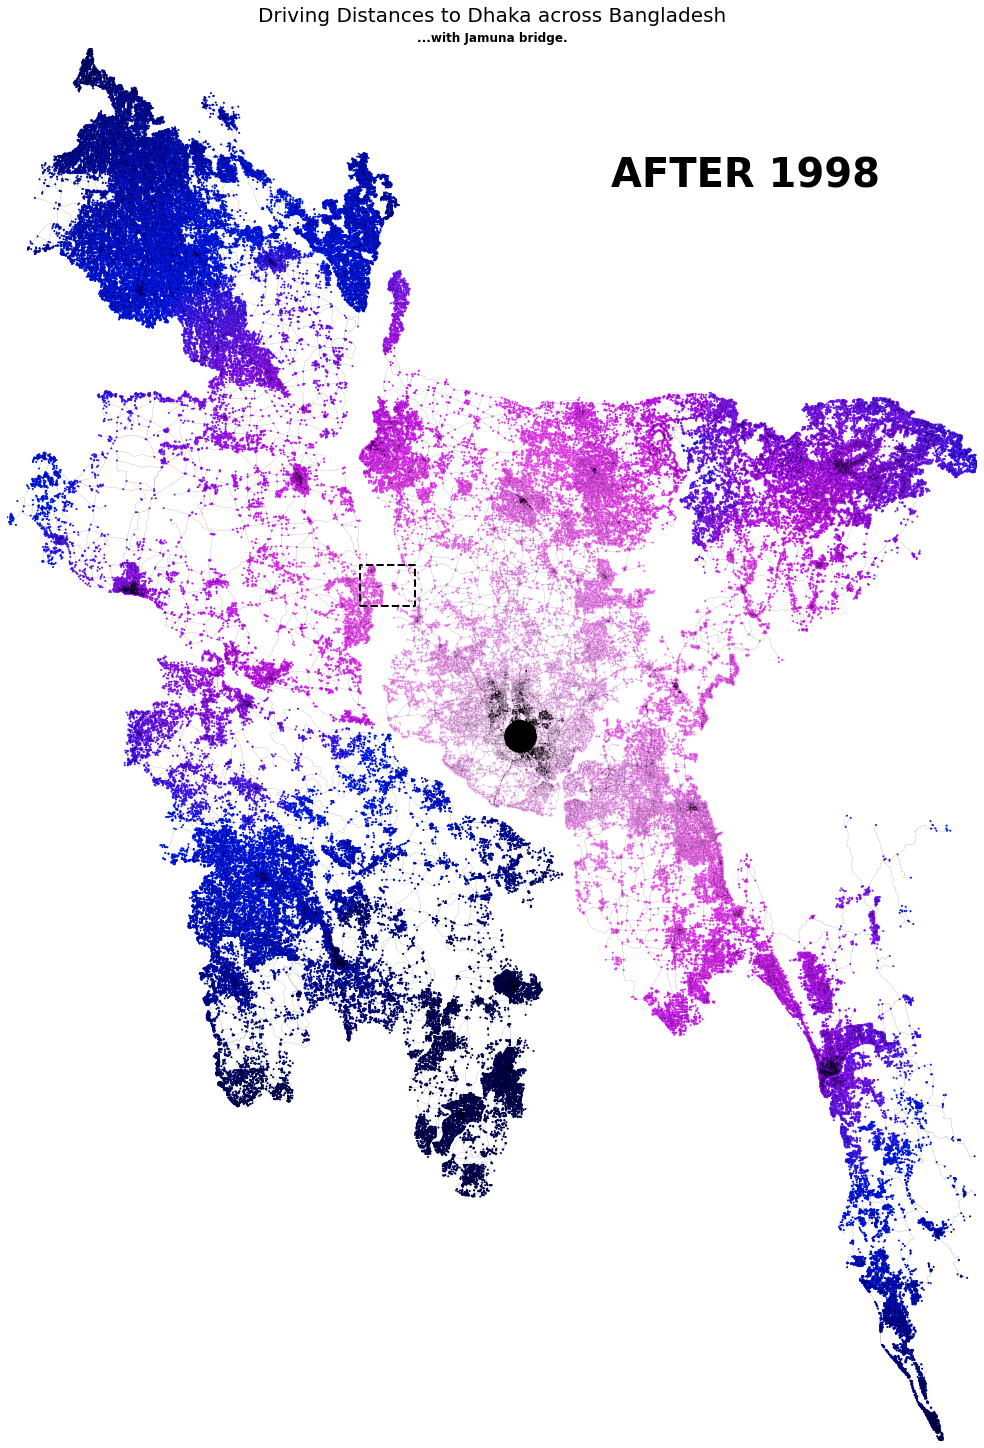

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20), 
                       facecolor='w',                       
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

E_mid.plot(color='k', linewidth=0.05, ax=ax)

N_mid.merge(mid_distances, 
            left_on='osmid', 
            right_on='osmid', 
            how='left').to_crs(3857).plot('distance', markersize=1, cmap=col, ax=ax,
                                         vmin=pre_distances.distance.min(),
                                         vmax=pre_distances.distance.max())

aoi_j.boundary.plot(color='k', linestyle='dashed', linewidth=2, ax=ax)

N[N.index==dhaka].plot(color='k', markersize=1000, ax=ax)

ax.text(0.9, 0.9,
        "AFTER 1998",
        color="k",
        weight='bold',
        fontsize=40,
        ha="right",
        transform=ax.transAxes,
       )

ax.set_xlim((N.geometry.x.min(), N.geometry.x.max()))
ax.set_ylim((N.geometry.y.min(), N.geometry.y.max()))

ax.set_title("...with Jamuna bridge.", color='k', weight='bold')

ax.set_axis_off()

fig.suptitle("Driving Distances to Dhaka across Bangladesh", fontsize=20, color='k')
fig.savefig('./images/scenarios/bangladesh-2.png', facecolor=fig.get_facecolor(), dpi=300, bbox_inches='tight')

In [69]:
%time post_isolines = nx.single_source_dijkstra(G, dhaka, weight='length')

CPU times: user 4.09 s, sys: 448 ms, total: 4.54 s
Wall time: 4.54 s


In [70]:
post_distances = pd.DataFrame({'osmid': post_isolines[0].keys(), 'distance': post_isolines[0].values()})

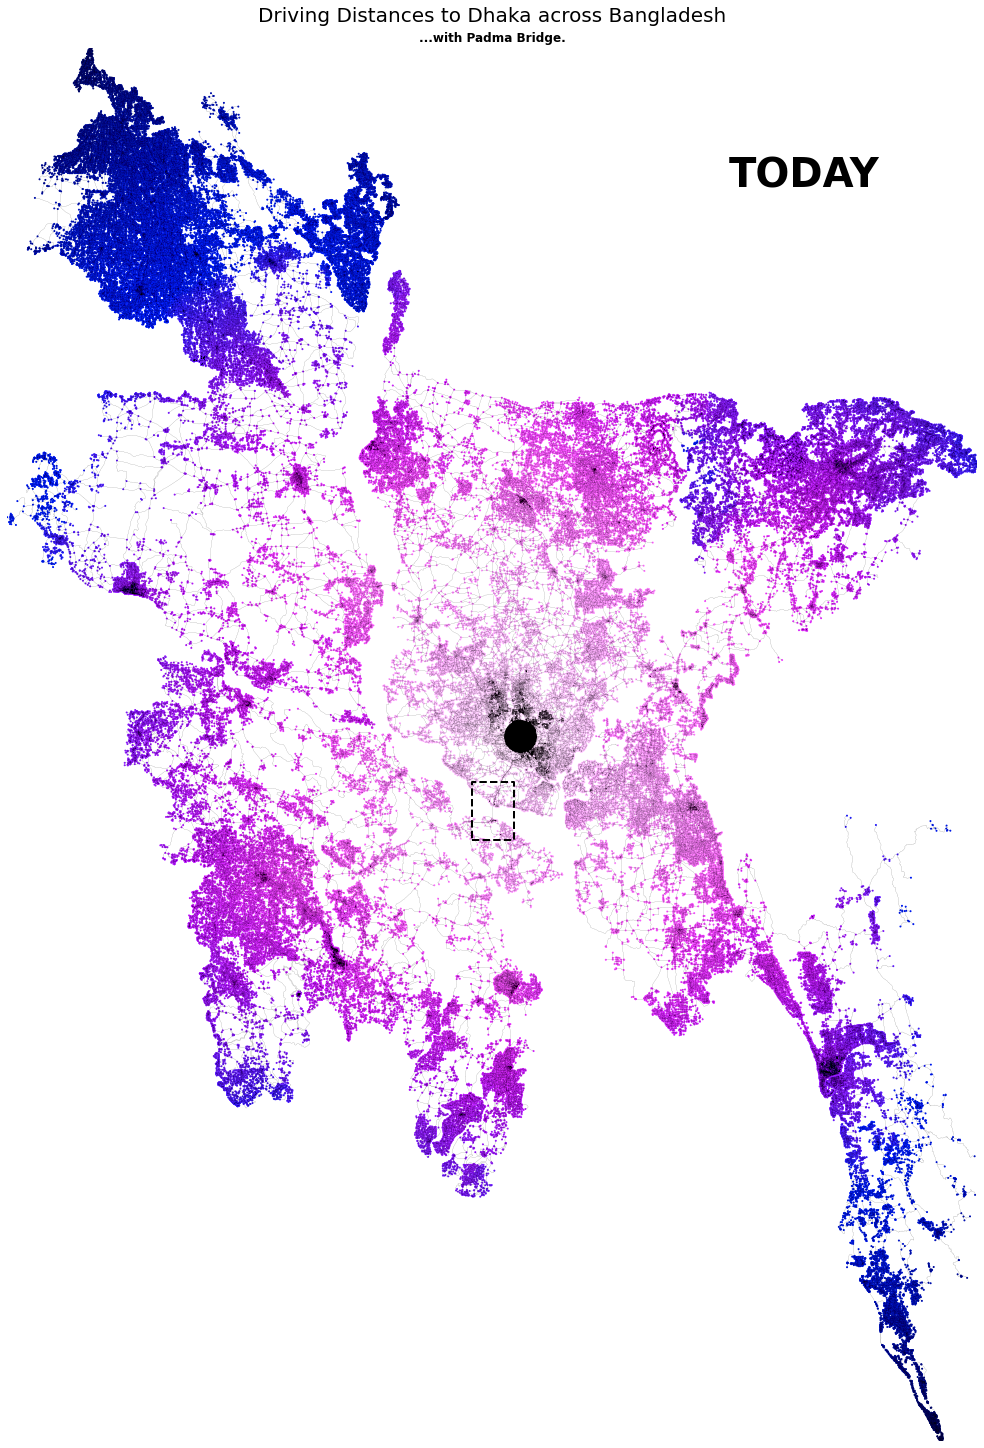

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20), 
                       facecolor='w',
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

E.plot(color='k', linewidth=0.05, figsize=(20, 20), ax=ax)

N.merge(post_distances, 
        left_on='osmid', 
        right_on='osmid', 
        how='left').to_crs(3857).plot('distance', markersize=1, cmap=col, ax=ax,
                                     vmin=pre_distances.distance.min(),
                                     vmax=pre_distances.distance.max())

aoi_p.boundary.plot(color='k', linestyle='dashed', linewidth=2, ax=ax)

N[N.index==dhaka].plot(color='k', markersize=1000, ax=ax)

ax.text(0.9, 0.9,
        "TODAY",
        color="k",
        weight='bold',
        fontsize=40,
        ha="right",
        transform=ax.transAxes,
       )

ax.set_xlim((N.geometry.x.min(), N.geometry.x.max()))
ax.set_ylim((N.geometry.y.min(), N.geometry.y.max()))

ax.set_title("...with Padma Bridge.", color='k', weight='bold')

ax.set_axis_off()

fig.suptitle("Driving Distances to Dhaka across Bangladesh", fontsize=20, color='k')
fig.savefig('./images/scenarios/bangladesh-3.png', facecolor=fig.get_facecolor(), dpi=300, bbox_inches='tight')

In [73]:
import imageio, os
# get the file paths of the images
imgs = os.listdir("./images/scenarios/")
# sort the images so the order is correct
imgs.sort()
# load the images
imgs = [imageio.imread(f"./images/scenarios/{x}") for x in imgs] 
# save the gif
imageio.mimsave("./images/scenarios.gif", imgs, fps=0.5);